In [ ]:
#| default_exp svm

In [1]:
#|export
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from torch import tensor

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

import logomaker

## One-hot encoding DNA sequences

In [2]:
#|export
def dna_encode(dna):
    nt_dict = {'A': [1,0,0,0], 
              'T': [0,1,0,0],
              'G': [0,0,1,0],
              'C': [0,0,0,1],
              'N': [0,0,0,0]}
    
    encoded_seqs = []
    for seq in dna:
        encoded = [nt_dict.get(nt, [0,0,0,0]) for nt in seq.upper()]
        encoded_seqs.append(tensor(encoded).T)
    
    return torch.stack(encoded_seqs)

## Reverse complement augmentation

In [5]:
#|export
def revcomp(seq):
    comp = {'A':'T','T':'A','C':'G','G':'C'}
    return ''.join(comp[b] for b in seq[::-1])

## Load and process dataset

In [6]:
train_df = pd.read_csv('./sp1_ml_datasets/train.tsv', sep="\t", header=None)
train_df

,0,1,2,3,4
0,CCTCCAGTCTCTGCACACTCCCAGCTGCAGCAGAGCCGGAGGAGAG...,1,chr1,191401,191601
1,CCTCTATGGTGTCGGCGAAGACCCGCCCTTGTGACGTCACGGAAGG...,1,chr1,778656,778856
2,CCGGGTGTGGAGGACGCCGCAGGGAGGGGACTGCGTGGCTGGGTTT...,1,chr1,827411,827611
3,TCTCTGTCCTTCATGGTGCATCCTCCTGTTGACTCCTGACCATCTG...,1,chr1,830832,831032
4,GGAGGAGTTTCTCTTTCCTAGGGTACACGTGGACATGCCTATGACT...,1,chr1,831163,831363
...,...,...,...,...,...
1572,GACGCGCAGATGGGCCCAGCCACCCAGCGGGGCGGCAGCCCTGAGC...,0,chr9,3181705,3181905
1573,CACTATCTTCACCTGTGGTTGAGAGCAAAACCACCATAAAGACAGT...,0,chr9,3240757,3240957
1574,GCATATGCAACCTGGAATGGAAAGAACAGAGGACAATGCTGCTCTT...,0,chr9,3467715,3467915
1575,AATTGTTAACACTCTACTGCGGGGAAGGAGGATCATCAAAGTGAAA...,0,chr9,3524675,3524875


In [7]:
x_train, y_train = dna_encode(train_df[0]), tensor(train_df[1])

### Shuffle the dataset 

Because of the way they were generated, positives and negatives were separated into the first and second half of the dataset.

In [8]:
idx = torch.randperm(x_train.size(0))
x_train, y_train = x_train[idx], y_train[idx]

In [9]:
y_train[:20]

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])

### Test set

In [10]:
test_df = pd.read_csv('./sp1_ml_datasets/test.tsv', sep="\t", header=None)
x_test, y_test = dna_encode(test_df[0]), tensor(test_df[1])
idx = torch.randperm(x_test.size(0))
x_test, y_test = x_test[idx], y_test[idx]

In [11]:
x_test.shape, y_test.shape

(torch.Size([455, 4, 200]), torch.Size([455]))

## Applying a SVM

### Input data must be 2D matrix 

In [12]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

torch.Size([1577, 800])

In [13]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [14]:
model = LinearSVC(C=1.0, max_iter=5000, dual=False)

In [15]:
model.fit(x_train, y_train)

/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=5000)

In [16]:
x_test = x_test.reshape(x_test.shape[0], -1)
x_test.shape

torch.Size([455, 800])

In [17]:
x_test = scaler.transform(x_test)

In [18]:
preds = model.predict(x_test)

In [19]:
y_scores = model.decision_function(x_test)

In [20]:
print("Accuracy:", accuracy_score(y_test, preds))
print("AUROC:", roc_auc_score(y_test, y_scores))
print("AUPRC:", average_precision_score(y_test, y_scores))

Accuracy: 0.567032967032967
AUROC: 0.6036078431372549
AUPRC: 0.5719852063556476


In [21]:
#|export
def get_metrics(model, x_test, y_test):
    preds = model.predict(x_test)
    try:
        y_scores = model.predict_proba(x_test)
    except AttributeError:
        y_scores = model.decision_function(x_test)
    acc, auc, avg_prec = accuracy_score(y_test, preds), roc_auc_score(y_test, y_scores), average_precision_score(y_test, y_scores)
    print("Accuracy:", acc)
    print("AUROC:", auc)
    print("AUPRC:", avg_prec)

## Hyperparameter tuning

In [22]:
param_grid = {"C": [0.01, 0.1, 1.0, 10, 100]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring="average_precision",
cv=5)

In [23]:
grid.fit(x_train, y_train)

/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [24]:
grid.best_score_, grid.best_params_

(0.6137552460839439, {'C': 0.01})

In [25]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.5736263736263736
AUROC: 0.6074705882352942
AUPRC: 0.5816984492111039


## Data augmentation: reverse complement

In [26]:
x_train_aug, y_train_aug = torch.cat((dna_encode(train_df[0]), dna_encode(rev_comp(train_df[0]))), dim=0), torch.cat((tensor(train_df[1]), tensor(train_df[1])), dim=0)
x_train_aug.shape, y_train_aug.shape

(torch.Size([3154, 4, 200]), torch.Size([3154]))

In [27]:
idx = torch.randperm(x_train_aug.shape[0])
x_train_aug, y_train_aug = x_train_aug[idx], y_train_aug[idx]

In [28]:
y_train_aug[:20]

tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [29]:
x_train_aug = x_train_aug.reshape(x_train_aug.shape[0], -1)
x_train_aug.shape

torch.Size([3154, 800])

In [30]:
#|export
def aug_preprocess(df):
    x, y = torch.cat((dna_encode(df[0]), dna_encode(rev_comp(df[0]))), dim=0), torch.cat((tensor(df[1]), tensor(df[1])), dim=0)
    idx = torch.randperm(x.shape[0])
    x, y = x[idx], y[idx]
    x = x.reshape(x.shape[0], -1)
    return x,y

In [31]:
scaler = StandardScaler()
x_train_aug = scaler.fit_transform(x_train_aug)

In [32]:
grid.fit(x_train_aug, y_train_aug)

/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/layaasiv/miniconda3/envs/tfbs-cls/lib/python3.9/site-packages/sklearn/svm/_base.

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [33]:
x_test, y_test = dna_encode(test_df[0]), tensor(test_df[1])
idx = torch.randperm(x_test.shape[0])
x_test, y_test = x_test[idx], y_test[idx]
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = scaler.transform(x_test)

In [34]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.5824175824175825
AUROC: 0.6310980392156863
AUPRC: 0.5955273494675454


That really helped improve performance!

## Trying a smaller peak window - 30bps

### Load data

In [35]:
train_df = pd.read_csv('sp1_ml_datasets/train_30bp.tsv', sep='\t', header=None)
train_df

,0,1,2,3,4
0,CCTGCGTCACTGGGCACAGACGCCAGTGAG,1,chr1,191486,191516
1,GAGCCAATCAGAACTCGCGGTGGGGGCTGC,1,chr1,778741,778771
2,GGCTCCGGATAATCCGTTTCCGGGTCAACA,1,chr1,827496,827526
3,CTCCCTTGGCAGCTCTCAGCTGTCTGTATC,1,chr1,830917,830947
4,TTGCAGGTCACAAGCAGGCTATCAGctcag,1,chr1,831248,831278
...,...,...,...,...,...
1856,TGGGGTTTGGAAGCAAAAGGGTGACACCTG,0,chr9,3181790,3181820
1857,AGAGTGTGGCAAAGTGGCCAGTAGGTGGCA,0,chr9,3240842,3240872
1858,TAGGGCTTCCCCTCCCCGCCTCCCACAGAC,0,chr9,3467800,3467830
1859,ATAAAGCACTGTCAATAACTACTAACCCAA,0,chr9,3524760,3524790


In [36]:
#|export
def preprocess(df):
    x, y = dna_encode(df[0]), tensor(df[1])
    idx = torch.randperm(x.shape[0])
    x, y = x[idx], y[idx]
    x = x.reshape(x.shape[0], -1)
    return x, y

In [37]:
x_train, y_train = preprocess(train_df)

In [38]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

### Apply SVM

In [41]:
param_grid = {"C": [0.01, 0.1, 1.0, 10, 100]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring="average_precision",
cv=5)

In [42]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [43]:
grid.best_score_, grid.best_params_

(0.6622214056200402, {'C': 0.01})

### Evaluate

In [44]:
test_df = pd.read_csv('sp1_ml_datasets/test_30bp.tsv', sep='\t', header=None)
test_df

,0,1,2,3,4
0,CTGTTTGCTCTACCTCTCCCCCTCCTAACA,1,chr20,257531,257561
1,ACCGGGGACAATAGCCCCGCGGGAGTGGGG,1,chr20,290412,290442
2,TCCGGGCGCCCCATCCCGCTGCGGACGGAG,1,chr20,297327,297357
3,CCACCAATGCGCTTCGACCCTGCCCTCCTT,1,chr20,310661,310691
4,CCCCAGGACTGGCTCCGCCCCGTGCCCCTG,1,chr20,324557,324587
...,...,...,...,...,...
450,gtagttctttttttaacaGGCATAGGTTCC,0,chrY,19567120,19567150
451,ACCCTTTCCAGTCCCTGCCGTCGCCTTATT,0,chrY,19567620,19567650
452,TTGCAGATGCCAGACTTCTCTGCTATGGGC,0,chrY,19744400,19744430
453,CTCACTCCGCGGATCGATTTTTCCGGCGCT,0,chrY,19744740,19744770


In [45]:
x_test, y_test = preprocess(test_df)

In [46]:
x_test = scaler.transform(x_test)
x_test.shape

(455, 120)

In [47]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.6
AUROC: 0.6585098039215687
AUPRC: 0.5863583720971008


### Adding augmentation

In [48]:
x_train_aug, y_train_aug = aug_preprocess(train_df)

In [49]:
scaler = StandardScaler()
x_train_aug = scaler.fit_transform(x_train_aug)

In [50]:
param_grid = {"C": [0.01, 0.1, 1.0, 10, 100]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring="average_precision",
cv=5)

In [51]:
grid.fit(x_train_aug, y_train_aug)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [52]:
grid.best_score_, grid.best_params_

(0.664590338314046, {'C': 0.01})

In [53]:
x_test, y_test = dna_encode(test_df[0]), tensor(test_df[1])
idx = torch.randperm(x_test.shape[0])
x_test, y_test = x_test[idx], y_test[idx]
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = scaler.transform(x_test)

In [54]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.6175824175824176
AUROC: 0.6791764705882353
AUPRC: 0.6113726093691131


## Visualize predicted SP1 motif

In [55]:
best_model = grid.best_estimator_

In [56]:
best_model.coef_.shape

(1, 120)

Convert into a `(4,W)` motif matrix:

In [57]:
W = best_model.coef_.shape[1] // 4 
motif = best_model.coef_.reshape(4,W)

In [58]:
# zero-mean per position
motif_norm = motif - motif.mean(axis=0, keepdims=True)

In [59]:
#|export
def get_motif(model):
    best_model = grid.best_estimator_
    W = best_model.coef_.shape[1] // 4 
    motif = best_model.coef_.reshape(4,W)
    return motif - motif.mean(axis=0, keepdims=True) # normalize by zero-centering

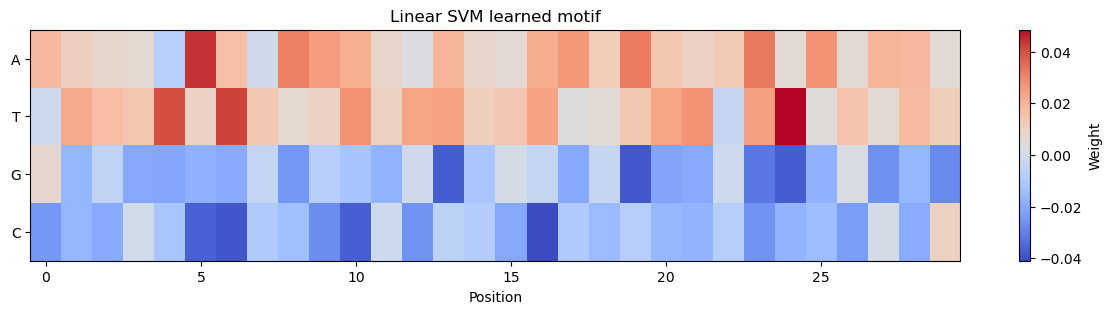

In [60]:
plt.figure(figsize=(W/2, 3))
plt.imshow(motif_norm, aspect="auto", cmap="coolwarm")
plt.colorbar(label="Weight")
plt.yticks([0,1,2,3], ["A", "T", "G", "C"])
plt.xlabel("Position")
plt.title("Linear SVM learned motif")
plt.show();

### Logomaker

In [61]:
# !pip install logomaker

<Figure size 640x480 with 0 Axes>

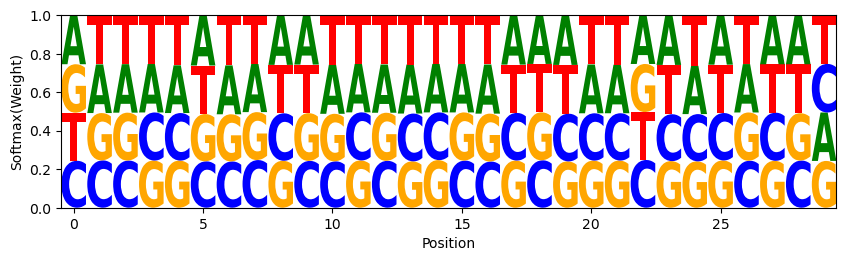

In [66]:
import logomaker

beta = 1.0
pwm = np.exp(beta * motif)
pwm /= pwm.sum(axis=0, keepdims=True)

df_pwm = pd.DataFrame(
    pwm.T,
    columns=["A", "T", "G", "C"]
)
plt.figure()
logomaker.Logo(df_pwm);
plt.xlabel("Position")
plt.ylabel("Softmax(Weight)");

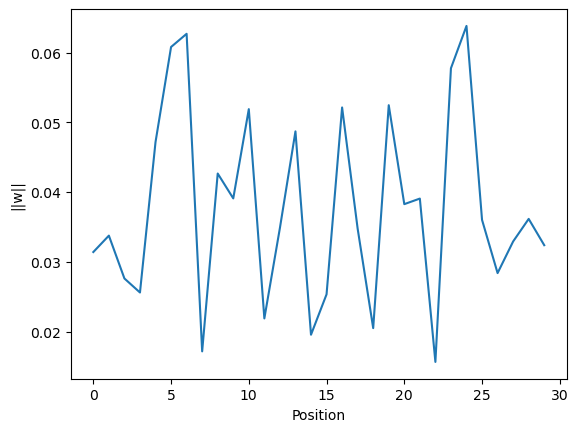

In [68]:
# positional importance
importance = np.linalg.norm(motif, axis=0)
plt.plot(importance)
plt.ylabel("||w||")
plt.xlabel("Position");

In [69]:
#|export
def vis_motif(motif):
    W = motif.shape[1]

    df = pd.DataFrame(
        motif.T,
        columns=["A", "T", "G", "C"]
    )

    fig, axs = plt.subplots(3, 1, figsize=(8,10))

    im = axs[0].imshow(
        motif,
        aspect="auto",
        cmap="coolwarm",
        origin="lower"
    )
    fig.colorbar(im, ax=axs[0], label="Weight")

    axs[0].set_yticks([0,1,2,3])
    axs[0].set_yticklabels(["A", "T", "G", "C"])
    axs[0].set_xlabel("Position")
    axs[0].set_title("Linear SVM weights")
    
    beta = 1.0
    pwm = np.exp(beta * motif)
    pwm /= pwm.sum(axis=0, keepdims=True)

    df_pwm = pd.DataFrame(
        pwm.T,
        columns=["A", "T", "G", "C"]
    )
    logomaker.Logo(df_pwm, ax=axs[1])
    axs[1].set_xlabel("Position")
    axs[1].set_ylabel("Softmax(Weight)");
    
    importance = np.linalg.norm(motif, axis=0)
    axs[2].plot(importance)
    axs[2].set_ylabel("||w||")
    axs[2].set_xlabel("Position");

    plt.tight_layout()
    plt.show()


In [70]:
# reverse complement the motif
motif_rc = motif_norm[[1,0,3,2], ::-1]

# correlation between motif and RC
corr = np.corrcoef(motif_norm.flatten(), motif_rc.flatten())[0,1]
print("Strand symmetry correlation:", corr)

Strand symmetry correlation: 0.9592733276805187


## Troubleshooting

In [71]:
#|export
def gc_content(dna):
    gc_count = 0
    for nt in dna.upper():
        if nt in ["C", "G"]: gc_count += 1
    return gc_count/len(dna)

In [72]:
gc_pos = []
gc_neg = []

In [74]:
for seq in train_df[train_df[1]==1][0]:
    gc_pos.append(gc_content(seq))

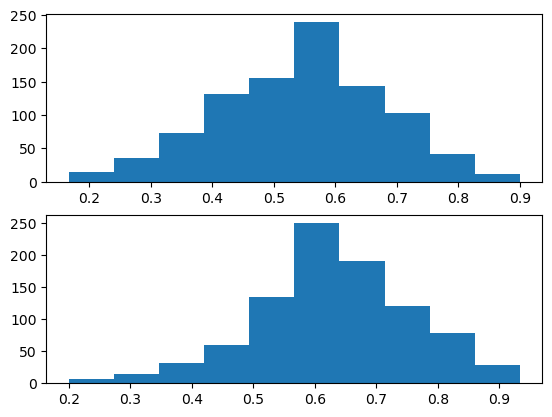

In [75]:
fig,ax = plt.subplots(2)
ax[0].hist(gc_pos); 
ax[1].hist(gc_neg);

In [76]:
abs(tensor(gc_pos).mean(dim=0) - tensor(gc_neg).mean(dim=0))

tensor(0.0874)

### Using upstream/downstream regions from summit as negative samples

In [77]:
flanks_trn = pd.read_csv('sp1_ml_datasets/flanks_train_30bp.tsv', sep='\t', header=None)

In [78]:
gc_pos = []
gc_neg = []

In [80]:
for seq in flanks_trn[flanks_trn[1]==1][0]:
    gc_pos.append(gc_content(seq))

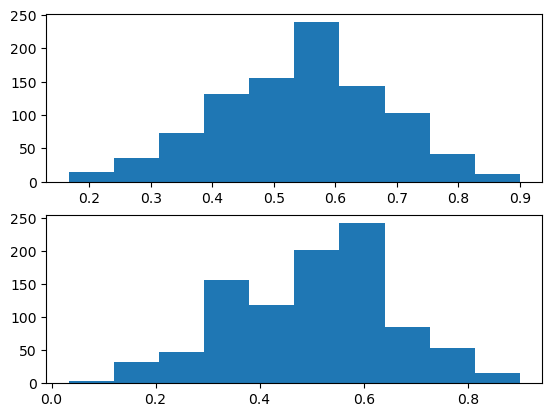

In [81]:
fig,ax = plt.subplots(2)
ax[0].hist(gc_pos); 
ax[1].hist(gc_neg);

In [82]:
abs(tensor(gc_pos).mean(dim=0) - tensor(gc_neg).mean(dim=0))

tensor(0.0411)

## Re-run SVM on new dataset

In [83]:
x_train, y_train = preprocess(flanks_trn)

In [84]:
scaler = StandardScaler()

In [85]:
x_train = scaler.fit_transform(x_train)

In [86]:
param_grid = {"C": [0.01, 0.1, 1.0, 10, 100]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring="average_precision",
cv=5)

In [87]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [88]:
grid.best_score_, grid.best_params_

(0.5190627089527146, {'C': 0.01})

In [89]:
flanks_test = pd.read_csv('sp1_ml_datasets/flanks_test_30bp.tsv', sep='\t', header=None)

In [90]:
x_test,y_test = preprocess(flanks_test)
x_test.shape, y_test.shape, y_test[:10]

(torch.Size([396, 120]),
 torch.Size([396]),
 tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0]))

In [91]:
x_test = scaler.transform(x_test)

In [92]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.5404040404040404
AUROC: 0.5569642857142857
AUPRC: 0.5528784653512364


In [93]:
motif = get_motif(grid)

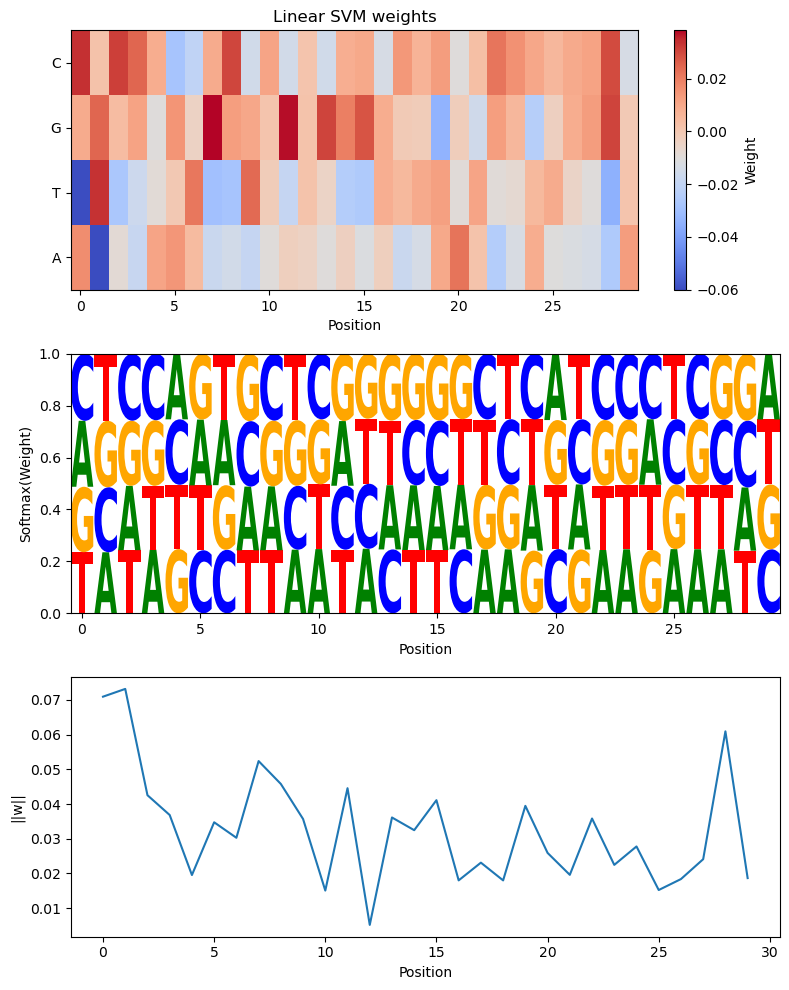

In [94]:
vis_motif(motif)

### Data augmentation

In [95]:
x_train,y_train = aug_preprocess(flanks_trn)
x_train.shape, y_train.shape, y_train[:10]

(torch.Size([3808, 120]),
 torch.Size([3808]),
 tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 0]))

In [96]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [97]:
param_grid = {"C": [0.01, 0.1, 1.0, 10, 100]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring="average_precision",
cv=5)

In [98]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             scoring='average_precision')

In [99]:
grid.best_score_, grid.best_params_

(0.5321269398263915, {'C': 0.01})

In [100]:
x_test,y_test = preprocess(flanks_test)
x_test.shape, y_test.shape, y_test[:10]

(torch.Size([396, 120]),
 torch.Size([396]),
 tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0]))

In [101]:
x_test = scaler.transform(x_test)

In [102]:
get_metrics(grid, x_test, y_test)

Accuracy: 0.5353535353535354
AUROC: 0.5512244897959183
AUPRC: 0.5563870181068199


In [103]:
motif = get_motif(grid)

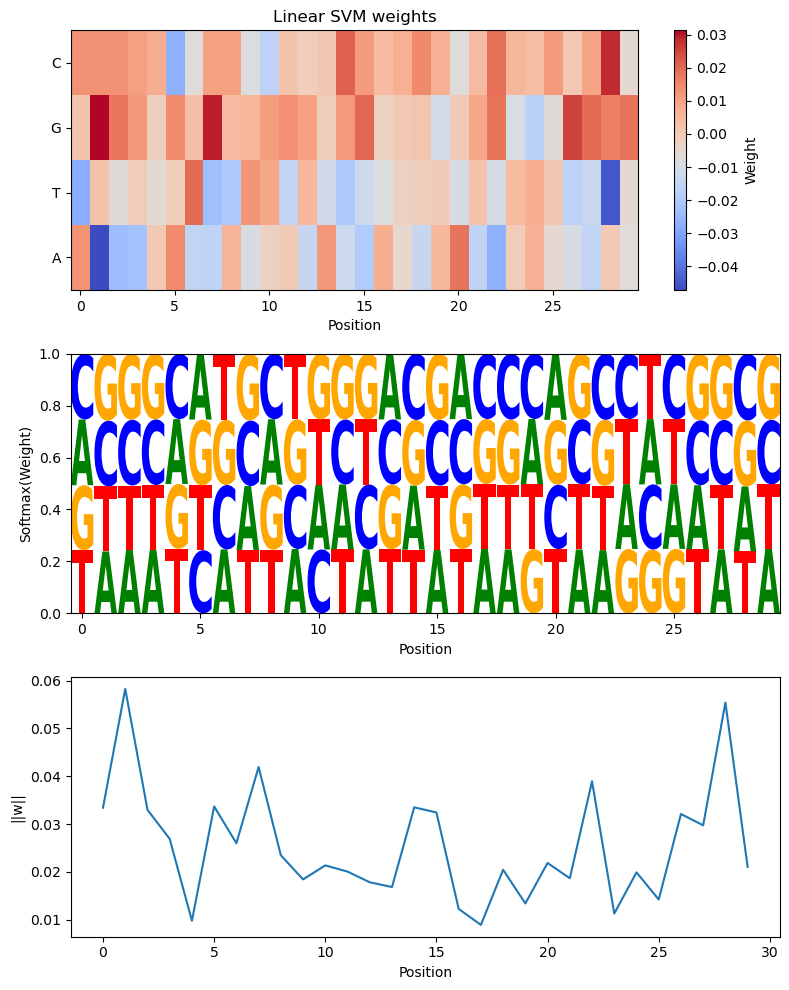

In [104]:
vis_motif(motif)

## Determining motif length

In [106]:
l2_motif = np.linalg.norm(motif, axis=0)

In [109]:
(l2_motif >= 0.5*l2_motif.max()).sum()

11

In [110]:
sorted_pos = np.argsort(l2_motif)[::-1]
sorted_imp = l2_motif[sorted_pos]

cum_imp = np.cumsum(sorted_imp)
L_80 = np.searchsorted(cum_imp, 0.8 * cum_imp[-1]) + 1
L_80

20

In [ ]:
import nbdev
nbdev.export.nb_export('svm.ipynb', './modules')